<a href="https://colab.research.google.com/github/Lorenzo-Gardini/DeepLearnig/blob/main/Manual_implementation_DQN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Authors
The authors of this code, this notebook and its documentation are [Lorenzo Gardini](mailto: lorenzo.gardini7@studio.unibo.it) and [Vlad Mattiussi](mailto: vlad.mattiussi@studio.unibo.it).

prendi spunto da https://colab.research.google.com/drive/1f9BxFxPxhPKUba8Ifcq4juv042ZA484-

In [ ]:
%autosave 60

In [6]:
%%capture
!pip install stable-baselines3[extra] ale-py==0.7.4 pyvirtualdisplay tensorflow

In [ ]:
!pip uninstall gym
!pip install gym[atari,accept-rom-license]==0.21.0

# Analisi del problema

il nostro obiettivo è quello di insegnare alla macchina a giocare correttamente al gioco "Pong" per consolle Atari (https://en.wikipedia.org/wiki/Pong). L'obiettivo del gioco è quello di colpire una palla, simulata da un piccolo quadrato, e rispedirla dall'altra parte: il giocatore che non riesce a rispedire la palla concede un punto al suo avversario. Il primo giocatore che raggiunge 21 punti vince la partita.
Per risolvere il problema si propone di ricorrere agli strumenti di reinforcement learning. Quindi si pensa di addestrare un modello basato su alcuni algoritmi. Gli algoritmi utilizzati saranno DQN, DDQN, con experience replay, con prioritized experience replay e Dueling DQN sia di studiare ed utilizzare algoritmi policy based (PPO e A2C).

<img src=https://www.gymlibrary.dev/_images/pong.gif width="300">

**Ambiente d'addestramento:**

Per l'ambiente di addestramento utiliziamo la libreria Gym, la quale ci fornisce il gioco di Pong.
Gym implements the classic “agent-environment loop”: The agent performs some actions in the environment (usually by passing some control inputs to the environment, e.g. torque inputs of motors) and observes how the environment’s state changes. One such action-observation exchange is referred to as a timestep.

<img src=https://www.gymlibrary.dev/_images/AE_loop_dark.png width="500">

L'obiettivo in RL è quello di manipolare l'ambiente in qualche modo specifico. Ad esempio, vogliamo che l'agente guidi un robot in un punto specifico nello spazio. Se riesce a farlo (o fa qualche progresso verso quell'obiettivo), riceverà una ricompensa positiva insieme all'osservazione per questo passo temporale. La ricompensa può anche essere negativa o 0, se l'agente non ha ancora avuto successo (o non ha fatto alcun progresso). L'agente sarà quindi addestrato per massimizzare la ricompensa che accumula in molti passaggi temporali.

Gli spazi vengono solitamente utilizzati per specificare il formato delle azioni e delle osservazioni valide. Ogni ambiente dovrebbe avere gli attributi action_space e observation_space, entrambi dovrebbero essere istanze di classi che ereditano dallo spazio. Ci sono più tipi di spazio disponibili in gym, nel nostro caso sara' discreto, cioe' descrive uno spazio discreto dove {0, 1, ..., n-1} sono i possibili valori che la nostra osservazione o azione può assumere. I valori possono essere spostati in  {a, a+1, ..., a+n-1} utilizzando un argomento facoltativo. Le azioni di Pong saranno 3: su, giu e stare fermi. Per quanto riguarda l'osseravzione per impostazione predefinita, l'ambiente restituisce l'immagine RGB visualizzata ai giocatori umani come osservazione. Tuttavia, nel nostro caso sara' una immagine in scala di grigi (Box([[0 ... 0] ...  [0 ... 0]],  [[255 ... 255] ...  [255 ... 255]], (250, 160), uint8)).


Per l'addestramento si è utilizzato la libreria Stable-Baseline con alcune modifiche. Abbiamo modificato il codice della libreria estendendo le classi principali in modo da poter usare gli stessi parametri e struttura della rete usati da deep mind.



## IMPORTS

In [9]:
import gym
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from abc import abstractmethod
import random
import time
import random
import statistics
from glob import glob
import pandas as pd

# keras and tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.losses import Huber 
from keras.optimizers import Adam, SGD, RMSprop

# save model
import pickle

# video and images manipulation
from IPython.display import display, HTML
from base64 import b64encode
from gym.wrappers import RecordVideo
from stable_baselines3.common.atari_wrappers import AtariWrapper

from skimage import transform
from skimage.color import rgb2gray

## COMMON CONSTANTS


In [ ]:
ENV_NAME = "ALE/Pong-v5"
data_path = "data"

### Display functions

In [ ]:
VIDEO_FOLDER = "./video"

def make_env():
  return gym.make(ENV_NAME)

def play_env(policy, steps):
  env = wrap_video_env(make_env())
  terminated = False
  observation = env.reset()

  for _ in range(steps):
    observation, reward, terminated, _ = env.step(policy(observation))
    if terminated:
      break
  env.close()
  
def wrap_video_env(env):
  return RecordVideo(env, VIDEO_FOLDER)


def show_video():
  mp4 = open(VIDEO_FOLDER + "/rl-video-episode-0.mp4",'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  display(HTML(f""" <video controls autoplay><source src="%s" type="video/mp4"></video>""" % data_url))

## DQN architecture

Abbiamo utilizzato due modelli diversi di architettura DQN: uno "classico" e uno dueling. Di seguito mostrati in ordine.

La seguente immagine mostra l'architettura di DQN.

<img src=https://biolab.csr.unibo.it/ferrara/Courses/DL/Tutorials/RL/DQN_architecture.png width="1200">

Keras offre una vasta gamma di built-in layers pronti per l'uso, tra cui:
- [**Conv2D**](https://keras.io/api/layers/convolution_layers/convolution2d/) -  2D convolution layer;
- [**Flatten**](https://keras.io/api/layers/reshaping_layers/flatten/) - un semplice layer per appiattire l'input.

**Dueling DQN**:

Questo algoritmo divide i valori Q in due parti diverse, la funzione valore V(s) e la funzione vantaggio A(s, a).

La funzione valore V(s) ci dice quanta ricompensa raccoglieremo dallo stato s. E la funzione di vantaggio A(s, a) ci dice quanto sia migliore un'azione rispetto alle altre. Combinando il valore V e il vantaggio A per ogni azione, possiamo ottenere i valori Q:


<img src=https://miro.medium.com/max/720/1*81-seZY1rVwC0wzXBprFJg.png width="300" height= "50">

Ciò che l'algoritmo Dueling DQN propone è che la stessa rete neurale divida il suo ultimo strato in due parti, una delle quali per stimare la funzione del valore di stato per lo stato s (V(s)) e l'altra per stimare la funzione di vantaggio per ogni azione a (A(s, a)), e alla fine combina entrambe le parti in un unico output,  che stimerà i valori Q. Questa modifica è utile, perché a volte non è necessario conoscere il valore esatto di ogni azione, quindi solo imparare la funzione stato-valore può essere sufficiente in alcuni casi.

<img src=https://miro.medium.com/max/720/1*vkrLw_sgOgFeBUuZylhyFA.png width="800" height= "400">

Tuttavia, non è possibile addestrare la rete neurale semplicemente sommando le funzioni di valore e vantaggio. In Q=V+A, data la funzione Q, non possiamo determinare i valori di V e A, poiché ciò è "non identificabile". Per risolvere questo possiamo fare questo: forzare il valore Q più alto per essere uguale al valore V, facendo così in modo che il valore più alto nella funzione vantaggio sia zero e tutti gli altri valori negativi. Questo ci dirà esattamente il valore per V, e possiamo calcolare tutti i vantaggi da lì, risolvendo il problema. Ecco come lo addestreremmo:

<img src=https://miro.medium.com/max/720/1*RT7XmyYC8y9uI61tNB1KOQ.png width="500" height= "50">



In [ ]:
def write_data(values, path):
  try:
    with open(path, 'wb') as fp:
      pickle.dump(values, fp, protocol = pickle.HIGHEST_PROTOCOL)
      return True
  except:
    return False

def load_data(path):
  try:
    with open(path, "rb") as parameters:
      return pickle.load(parameters)
  except:
      return {}

In [ ]:
def build_dqn(input_shape=(84, 84, 4), action_count=3):
  model=keras.Sequential(
          [
            layers.Input(shape=input_shape,name='input'),
            layers.Conv2D(filters=32, kernel_size=8, strides=4,activation='relu',padding='valid',name='c1'),
            layers.Conv2D(filters=64, kernel_size=4,strides=2,activation='relu',padding='valid',name='c2'),
            layers.Conv2D(filters=64, kernel_size=3,strides=1,activation='relu',padding='valid',name='c3'),
            layers.Flatten(),
            layers.Dense(512, activation='relu',name='fc'),
            layers.Dense(units=action_count,activation='linear',name='output')
          ]
      )
  model.compile()
  return model

def build_dueling_dqn(input_shape=(84, 84, 4), action_count=3):
  input = layers.Input(shape=input_shape,name='input')
  conv_1 = layers.Conv2D(filters=32, kernel_size=8, strides=4,activation='relu',padding='valid')(input)
  conv_2 = layers.Conv2D(filters=64, kernel_size=4,strides=2,activation='relu',padding='valid')(conv_1)
  conv_3 = layers.Conv2D(filters=64, kernel_size=3,strides=1,activation='relu',padding='valid')(conv_2)
  flatten = layers.Flatten()(conv_3)
  # TODO AGGIUNGI FULLY CONNECTED DOPO FLATTEN

  state = layers.Dense(1,activation='linear',name='state')(flatten)
  raw_advantages = layers.Dense(action_count,activation='linear')(flatten)

  advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
  Q_values = state + advantages
  model = tf.keras.Model(inputs=[input], outputs=[Q_values])
  model.compile()
  return model

def build_action_target_dqn(input_shape=(84, 84, 4), action_count=3):
  action_model = build_dqn(input_shape, action_count)
  target_model = build_dqn(input_shape, action_count)
  target_model.set_weights(action_model.get_weights())
  return action_model, target_model

def build_dueling_action_target_dqn(input_shape=(84, 84, 4), action_count=3):
  action_model = build_dueling_dqn(input_shape, action_count)
  target_model = build_dueling_dqn(input_shape, action_count)
  target_model.set_weights(action_model.get_weights())
  return action_model, target_model

## Frame preprocessing

Per ridurre la complessità dello stato, e di conseguenza il tempo di calcolo, ogni fotogramma è:
1. trasformato in scala di grigi;
2. ritagliato per selezionare la regione di interesse;
3. ridimensionato a 84×84.

Inoltre, per ridurre l'occupazione di memoria del buffer di riproduzione, i valori dei pixel vengono memorizzati come byte (nell'intervallo [0;255]) e convertiti in valori a virgola mobile (nell'intervallo [0;1]) solo quando necessario come input per i  modelli *action*  o  *target*.

La seguente funzione esegue tali operazioni, date:
- il frame di ingresso (*frame*); 
- le coordinate della regione di interesse (*top_crop*, *bottom_crop*,  *left_crop*  e  *right_crop*); 
- la dimensione del telaio residuato (*resized_shape*).



In [ ]:
TOP_CROP = 14
BOTTOM_CROP = 196
LEFT_CROP = 8
RIGHT_CROP = -1
RESIZE_SHAPE = (84,84)

def preprocess_frame(frame):
  # 1. the input RGB frame is transformed in grayscale
  gray = rgb2gray(frame)
      
  # 2. the region of interest is cropped
  cropped_frame = gray[TOP_CROP:BOTTOM_CROP, LEFT_CROP:RIGHT_CROP]
  
  # 3. the resulting images is resized
  preprocessed_frame = transform.resize(cropped_frame, RESIZE_SHAPE)
  
  # convert float to byte
  byte_preprocessed_frame=(preprocessed_frame*255).astype('uint8')

  return byte_preprocessed_frame

def scale_frames(frames):
  return frames / 255.0

def preprocessed_env():
  return AtariWrapper(make_env())

### Visualize preprocessing

In [ ]:
env = preprocessed_env()
plt.axis('off')
frame = env.reset()
print(frame.squeeze().shape)
plt.imshow(frame.squeeze(), cmap='gray')
plt.show()

In [ ]:
env = make_env()
plt.axis('off')
frame = env.reset()
preprocessed_frame = preprocess_frame(frame)
print(preprocessed_frame.shape)
plt.imshow(preprocessed_frame, cmap='gray')
plt.show()

## Frame Stacking


Per risolvere il problema della limitazione temporale e dare alla rete il senso del movimento, DQN prende una pila di fotogrammi come input.

La seguente funzione impila i fotogrammi insieme:
- la nuova cornice da aggiungere (*new_frame*);
- il numero di fotogrammi da impilare (*frame_count*);
- i fotogrammi precedenti contenuti in un  oggetto **deque** (*deque_frames*).

Per i primi fotogrammi *new_frame*,  *frame_count*  identici  a *new_frame* vengono aggiunti a un nuovo  oggetto **deque**. In caso contrario,  il *new_frame* viene aggiunto alla deque che rimuove automaticamente il frame meno recente.


In [ ]:
class FramesStack:
  def __init__(self, initial_frame, frame_count, preprocess_frame):
    self._frame_count = frame_count
    self._preprocess_frame = preprocess_frame

    preprocessed_initial_frame = preprocess_frame(initial_frame)
    self._deque = deque([preprocessed_initial_frame for _ in range(frame_count)], maxlen=frame_count)
  
  def add(self, frame):
    self._deque.append( self._preprocess_frame(frame) )
    return self
  
  def stack(self):
    return np.stack(self._deque, axis=2)

## Replay memory

Per rimuovere le correlazioni tra transizioni consecutive e rendere l'allenamento DQN più stabile,  viene utilizzata la tecnica *experience replay*.

La memoria di riproduzione viene implementata come [**deque**](https://docs.python.org/3/library/collections.html#collections.deque) (Double Ended Queue) che fornisce una complessità temporale O(1) per le operazioni di accodamento e pop da entrambe le estremità della coda. Inoltre, se viene specificato il  parametro *maxlen*,  **deque** viene limitato alla lunghezza massima specificata. Una volta che una deque di lunghezza limitata è piena, quando vengono aggiunti nuovi elementi, un numero corrispondente di elementi viene scartato dall'estremità opposta.

Gli autori di DQN suggeriscono di popolare la memoria di riproduzione prima di iniziare il processo di apprendimento. Per ogni passaggio $t$, viene scelta ed eseguita un'azione casuale, quindi  la transizione $<s_t,a_t,r_{t+1},s_{t+1}>$ viene memorizzata nella memoria di riesecuzione. La seguente funzione inizializza la memoria di riproduzione fornita:
- l'ambiente (*env*);
- la memoria di replay (*replay_memory*);
- il numero di transizioni da memorizzare nella memoria di riproduzione (*replay_memory_init_size*);
- il numero massimo di passi per episodio (*episode_max_steps*). 




**Prioritized experience replay**:

È costruito su buffer di replay dell'esperienza, che consentono a un agente di apprendimento per rinforzo (RL) di memorizzare esperienze sotto forma di tuple di transizione, solitamente indicate come (st,at,rt,st+1) con stati, azioni, ricompense e stati successori in qualche momento indice t. A differenza del consumo di campioni online e scartarli successivamente, il campionamento dalle esperienze memorizzate significa che sono meno pesantemente "correlati" e possono essere riutilizzati per l'apprendimento.

Il campionamento uniforme da un buffer di riproduzione è una buona strategia predefinita e probabilmente la prima da tentare. Ma il campionamento prioritario, come suggerisce il nome, peserà i campioni in modo che quelli "importanti" vengano estratti più frequentemente per la formazione.


In [ ]:
class ReplayMemory:
  @abstractmethod
  def add_transition(self, transition):
    pass

  def _split_batch(self, batch):
    states, actions, rewards, next_states, dones =  [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5) 
          ]
    return scale_frames(states), actions, rewards, scale_frames(next_states), dones
  
  @abstractmethod
  def sample_batch(self, batch_size):
    pass

class AbstractReplayMemory(ReplayMemory):
  def __init__(self, max_size):
    self._buffer = deque(maxlen = max_size)

  def len(self):
    return len(self._buffer)

  @abstractmethod
  def add_transition(self, transition):
    pass
  
  @abstractmethod
  def sample_batch(self, batch_size):
    pass

class SimpleReplayMemory(AbstractReplayMemory):
  def __init__(self, max_size):
     super().__init__(max_size)

  def add_transition(self, transition):
    self._buffer.append(transition)
    return self

  def sample_batch(self, batch_size):
    indices = np.random.randint(len(self._buffer), size=batch_size)
    batch = [self._buffer[index] for index in indices]
    return self._split_batch(batch)


class PrioritizedReplayMemory(ReplayMemory):
  @abstractmethod
  def update_priorities(self, indices, losses):
    pass


class PrioritizedReplayMemoryImpl(AbstractReplayMemory, PrioritizedReplayMemory):
  def __init__(self, max_size, alpha = 0.6, error_offset = 0.1):
    super().__init__(max_size)
    self._alpha = alpha
    self._priorities = deque(maxlen = max_size)
    self._default_max_priority = 1
    self._error_offset = 0.1

  def _get_probabilities(self):
    scaled_priorities = np.array(self._priorities) ** self._alpha # pi^a
    sample_probabilities = scaled_priorities/ np.sum(scaled_priorities) # P(i) = pi^a/sum(p^a)
    return sample_probabilities

  def _get_importance(self, probabilities, beta):
    importance = (1/len(self._buffer) * 1/probabilities) ** beta # (1/N * 1/P(i))^b
    normalized_importance = importance / max(importance) # 1/maxi(wi), normalization
    return normalized_importance

  def update_priorities(self, indices, losses):
    for i,l in zip(indices, losses):
      self._priorities[i] = max(abs(l) + self._error_offset, self._default_max_priority)
    
    return self

  def add_transition(self, transaction):
    self._buffer.append(transaction)
    self._priorities.append(max(self._priorities, default = self._default_max_priority))

  def sample_batch(self, batch_size, beta):
    probs = self._get_probabilities()
    sampled_indices = random.choices(range(len(self._buffer)), k=batch_size, weights = probs)
    return (*self._split_batch(np.array(self._buffer)[sampled_indices]), self._get_importance(probs[sampled_indices], beta), sampled_indices)


class TreePrioritizedReplayMemory(PrioritizedReplayMemory):
  def __init__(self, capacity, alpha = 0.6, error_offset = 0.1):
    self._capacity = capacity
    self._alpha = alpha
    self._priority_sum = np.zeros(shape= 2 * capacity, dtype=np.float32)
    self._priority_min = [float('inf') for _ in range( 2 * self._capacity)]
    self._max_priority = 1
    self._data = [None for _ in range(self._capacity)]
    self._next_idx = 0
    self._size = 0
    self._error_offset = error_offset

  def len(self):
    return self._size

  def add_transition(self, transaction):
    idx = self._next_idx
    self._data[idx] = transaction
    self._next_idx = (idx + 1) % self._capacity
    self._size = min(self._capacity, self._size + 1)

    priority_alpha = self._max_priority ** self._alpha
    self._set_priority_min(idx, priority_alpha)
    self._set_priority_sum(idx, priority_alpha)

  def _set_priority_min(self, idx, priority_alpha):
    idx += self._capacity
    self._priority_min[idx] = priority_alpha

    while idx >= 2:
      idx //= 2
      self._priority_min[idx] = min(self._priority_min[2 * idx], self._priority_min[2 * idx + 1])

  def _set_priority_sum(self, idx, priority):
    idx += self._capacity
    self._priority_sum[idx] = priority
    while idx >= 2:
      idx //= 2
      self._priority_sum[idx] = self._priority_sum[2 * idx] + self._priority_sum[2 * idx + 1]

  def _sum(self):
    return self._priority_sum[1]

  def _min(self):
    return self._priority_min[1]

  def _find_prefix_sum_idx(self, prefix_sum):
    idx = 1
    while idx < self._capacity:
        if self._priority_sum[idx * 2] > prefix_sum:
          idx = 2 * idx
        else:
          prefix_sum -= self._priority_sum[idx * 2]
          idx = 2 * idx + 1
    return idx - self._capacity

  def sample_batch(self, batch_size, beta):
    weights = np.zeros(shape=batch_size, dtype=np.float32)
    indices = np.zeros(shape=batch_size, dtype=np.int32)

    # Get sample indices
    for i in range(batch_size):
      p = random.random() * self._sum()
      indices[i] = self._find_prefix_sum_idx(p)

    prob_min = self._min() / self._sum()
    max_weight = (prob_min * self._size) ** (-beta)

    for i in range(batch_size):
      idx = indices[i]
      prob = self._priority_sum[idx + self._capacity] / self._sum()
      weight = (prob * self._size) ** (-beta)
      weights[i] = weight / max_weight

    return (*self._split_batch(self._data[:self._size]), weights, indices)

  def update_priorities(self, indices, losses):
    priorities = np.abs(losses + self._error_offset)

    for idx, priority in zip(indices, priorities):
      self._max_priority = max(self._max_priority, priority)
      priority_alpha = priority ** self._alpha
      self._set_priority_min(idx, priority_alpha)
      self._set_priority_sum(idx, priority_alpha)

  def is_full(self):
    return self._capacity == self._size

In [ ]:
class TreePrioritizedReplayMemory(PrioritizedReplayMemory):
  def __init__(self, capacity, alpha=0.6, error_offset=0.1):
    # We use a power of $2$ for capacity because it simplifies the code and debugging
    self._capacity = capacity
    # $\alpha$
    self._alpha = alpha

    self._error_offset = error_offset

    # Maintain segment binary trees to take sum and find minimum over a range
    self._priority_sum = [0 for _ in range(2 * self._capacity)]
    self._priority_min = np.repeat([float('inf')], 2 * self._capacity)
    self._data = np.zeros(capacity, dtype=object)
    # Current max priority, $p$, to be assigned to new transitions
    self._max_priority = 1.

    # We use cyclic buffers to store data, and `next_idx` keeps the index of the next empty
    # slot
    self._next_idx = 0

    # Size of the buffer
    self._size = 0

  def len(self):
    return self._size

  def add_transition(self, transition):
    # Get next available slot
    idx = self._next_idx

    # store in the queue
    self._data[idx] = transition

    # Increment next available slot
    self._next_idx = (idx + 1) % self._capacity
    # Calculate the size
    self._size = min(self._capacity, self._size + 1)

    # $p_i^\alpha$, new samples get `max_priority`
    priority_alpha = self._max_priority ** self._alpha
    # Update the two segment trees for sum and minimum
    self._set_priority_min(idx, priority_alpha)
    self._set_priority_sum(idx, priority_alpha)

  def _set_priority_min(self, idx, priority_alpha):
    # Leaf of the binary tree
    idx += self._capacity
    self._priority_min[idx] = priority_alpha

    # Update tree, by traversing along ancestors.
    # Continue until the root of the tree.
    while idx >= 2:
      # Get the index of the parent node
      idx //= 2
      # Value of the parent node is the minimum of it's two children
      self._priority_min[idx] = min(self._priority_min[2 * idx], self._priority_min[2 * idx + 1])

  def _set_priority_sum(self, idx, priority):
    # Leaf of the binary tree
    idx += self._capacity
    # Set the priority at the leaf
    self._priority_sum[idx] = priority

    # Update tree, by traversing along ancestors.
    # Continue until the root of the tree.
    while idx >= 2:
      # Get the index of the parent node
      idx //= 2
      # Value of the parent node is the sum of it's two children
      self._priority_sum[idx] = self._priority_sum[2 * idx] + self._priority_sum[2 * idx + 1]

  def _sum(self):
    # The root node keeps the sum of all values
    return self._priority_sum[1]

  def _min(self):
    # The root node keeps the minimum of all values
    return self._priority_min[1]

  def _find_prefix_sum_idx(self, prefix_sum):
    # Start from the root
    idx = 1
    while idx < self._capacity:
      # If the sum of the left branch is higher than required sum
      if self._priority_sum[idx * 2] > prefix_sum:
        # Go to left branch of the tree
        idx = 2 * idx
      else:
        # Otherwise go to right branch and reduce the sum of left
        #  branch from required sum
        prefix_sum -= self._priority_sum[idx * 2]
        idx = 2 * idx + 1

    # We are at the leaf node. Subtract the capacity by the index in the tree
    # to get the index of actual value
    return idx - self._capacity

  def sample_batch(self, batch_size, beta):
    # Initialize samples
    weights = np.zeros(shape=batch_size, dtype=np.float32)
    indices = np.zeros(shape=batch_size, dtype=np.int32)

    # Get sample indices
    for i in range(batch_size):
      p = random.random() * self._sum()
      idx = self._find_prefix_sum_idx(p)
      indices[i] = idx

    # $\min_i P(i) = \frac{\min_i p_i^\alpha}{\sum_k p_k^\alpha}$
    prob_min = self._min() / self._sum()
    # $\max_i w_i = \bigg(\frac{1}{N} \frac{1}{\min_i P(i)}\bigg)^\beta$
    max_weight = (prob_min * self._size) ** (-beta)

    for i in range(batch_size):
      idx = indices[i]
      # $P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}$
      prob = self._priority_sum[idx + self._capacity] / self._sum()
      # $w_i = \bigg(\frac{1}{N} \frac{1}{P(i)}\bigg)^\beta$
      weight = (prob * self._size) ** (-beta)
      # Normalize by $\frac{1}{\max_i w_i}$,
      #  which also cancels off the $\frac{1}{N}$ term
      weights[i] = weight / max_weight

    return (*self._split_batch(self._data[indices]), weights, indices)

  def update_priorities(self, indexes, losses):
    priorities = np.abs(losses + self._error_offset)
    for idx, priority in zip(indexes, priorities):
      # Set current max priority
      self._max_priority = max(self._max_priority, priority)

      # Calculate $p_i^\alpha$
      priority_alpha = priority ** self._alpha
      # Update the trees
      self._set_priority_min(idx, priority_alpha)
      self._set_priority_sum(idx, priority_alpha)

In [ ]:
def dqn_replay_memory_init(env,
                           replay_memory,
                           replay_memory_init_size,
                           episode_max_steps,
                           preprocess_frame,
                           stacked_frame_count):
  loading_step = replay_memory_init_size/10

  while True:
    initial_state = env.reset()
    frames_stack = FramesStack(initial_state, stacked_frame_count, preprocess_frame)
    stacked_states = frames_stack.stack()

    done=False
    step_count=0

    while step_count < episode_max_steps and not done:
      if replay_memory.len() % loading_step == 0:
        print(f'Loaded: {int(replay_memory.len()/replay_memory_init_size * 100)}% ({replay_memory.len()})')

      action = env.action_space.sample()
      new_state, reward, done, _ = env.step(action)

      frames_stack.add(new_state)
      new_stacked_states = frames_stack.stack()

      replay_memory.add_transition([stacked_states, action, reward, new_stacked_states, done])
      stacked_states = new_stacked_states
      step_count+=1
      

      if replay_memory.len() >= replay_memory_init_size:
        return

## Epsilon update

In [ ]:
def update_epsilon(epsilon, min_epsilon, decay):
  return max(min_epsilon,epsilon-decay)

def update_beta(beta, max_beta, beta_increase):
  return min(max_beta, beta+beta_increase)

## Training

Per selezionare un'azione utilizzando questo DQN, è sufficiente selezionare l'azione con il valore Q più grande previsto. Tuttavia, per garantire che l'agente esplori l'ambiente, scegliamo un'azione casuale con probabilità epsilon.

In [ ]:
def epsilon_greedy_policy(action_model, state, epsilon=0):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        Q_values = action_model.predict(state[np.newaxis], verbose=False)
        return Q_values.argmax()  # optimal action according to the DQN

Loop del gioco: l'agente sceglie un'azione, la esegue e lo stato viene aggiornato.

In [ ]:
def game_loop(env, action_model, states, epsilon):
  float_states = scale_frames(states)
  action = epsilon_greedy_policy(action_model, float_states, epsilon)
  next_state, reward, done, _ = env.step(action)
  return action, reward, next_state, done

Data una transizione < st
, a
, rt+1, st+1 >, Q st 
, a può essere espresso dal Bellman
equazione in termini di valore Q dello stato successivo st+1:
𝑄 𝑠𝑡
, 𝑎𝑡 = 𝑟𝑡+1 + 𝛾 ⋅ max
𝑎
𝑄 𝑠𝑡+1.



La ricompensa massima futura per lo stato attuale e l'azione a
è la ricompensa immediata
RT+1 più la ricompensa massima futura per il prossimo stato ST+1.
In altre parole, invece di calcolare ogni valore come somma del cumulativo atteso.
ricompense (che è un processo lungo), questo equivale a sommare la ricompensa immediata e il
ricompensa futura scontata dello stato che segue.


Poiché il valore reale è sconosciuto (RL non è supervisionato e non sono disponibili etichette), verrà stimato usando l'equazione di Bellman:
yt = rt+1 + γ ⋅ max Q (a) (st+1,a)  



In [ ]:
# target Q values computation
def compute_Q_values(max_next_Q_values, reward_batch, done_batch, gamma):
  target_Q_values = reward_batch + (1 - done_batch) * gamma * max_next_Q_values
  target_Q_values = target_Q_values.reshape(-1, 1)
  return target_Q_values

def target_Q_values(target_model, new_state_batch, reward_batch, done_batch, gamma):
  next_Q_values = target_model.predict(new_state_batch, verbose=0)
  max_next_Q_values = next_Q_values.max(axis=1)
  target_Q_values = compute_Q_values(max_next_Q_values, reward_batch, done_batch, gamma)
  return max_next_Q_values

def double_DQN_values(action_model, target_model, new_state_batch, reward_batch, done_batch, gamma, n_actions):
  next_Q_values = action_model.predict(new_state_batch, verbose=0)  # ≠ target.predict()
  best_next_actions = next_Q_values.argmax(axis=1)
  next_mask = tf.one_hot(best_next_actions, n_actions).numpy()
  max_next_Q_values = (target_model.predict(new_state_batch, verbose=0) * next_mask).sum(axis=1)
  target_Q_values = compute_Q_values(max_next_Q_values, reward_batch, done_batch, gamma)
  return target_Q_values

I valori Q possono essere qualsiasi valore reale, il che lo rende un compito di regressione, che può essere ottimizzato
con una semplice perdita di errore quadrato.

Eseguite un passo di discesa del gradiente per aggiornare  i pesi Q riducendo al minimo la funzione di perdita.

Per risolvere il problema del bersaglio mobile, durante il processo di addestramento DQN vengono utilizzati due modelli (azione e bersaglio).


### **Action model update**
TLa seguente funzione aggiorna i pesi del modello di azione usando l'algoritmo *gradient descent* dato:
- il modello d'azione (*dqn_action_model*);
- il modello target (*dqn_target_model*);
- un mini-batch contenente transizioni $<s_i,a_i,r_{i+1},s_{i+1}>$ selezionate casualmente dalla memoria di replay (*mini_batch*); 
- il fattore di sconto $\gamma$ (gamma).

Per quanto riguarda la funzione **simple_dqn_update**,  qui i valori dei pixel contenuti in $s_i$ e $s_{i+1}$ (*state_batch* e *new_state_batch*, rispettivamente) vengono normalizzati nell'intervallo $[0;1]$ prima di essere utilizzati come input dei  metodi **predict**  e  **train_on_batch**.


**Double DQN:**

Uno dei problemi dell'algoritmo DQN è che sovrastima le vere ricompense; i valori Q pensano che l'agente otterrà un rendimento superiore a quello che otterrà nella realtà. Per risolvere questo problema, gli autori dell'algoritmo Double DQN [1] suggeriscono di utilizzare un semplice trucco: disaccoppiare la selezione dell'azione dalla valutazione dell'azione. Invece di usare la stessa equazione di Bellman dell'algoritmo DQN, la cambiano in questo modo:

<img src=https://miro.medium.com/max/720/1*OFYk-9yL6k8QiIUYjjTUXQ.png width="500" height= "50">

In primo luogo, la rete neurale principale θ decide quale sia la migliore azione successiva a' tra tutte le azioni successive disponibili, e quindi la rete neurale bersaglio valuta questa azione per conoscere il suo valore Q. Questo semplice trucco ha dimostrato di ridurre le sovrastime, il che si traduce in migliori politiche finali.

In [ ]:
# generic model update
def update_model(action_model, target_Q_values, state_batch, action_batch, optimizer, loss_fn, n_actions):
  mask = tf.one_hot(action_batch, n_actions)
  with tf.GradientTape() as tape:
    all_Q_values = action_model(state_batch)
    Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
    losses = loss_fn(target_Q_values, Q_values)
    loss = tf.reduce_mean(losses)

  grads = tape.gradient(loss, action_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, action_model.trainable_variables))
  return losses

def prioritized_model_update(action_model, target_model, target_Q_values_fn, batch, gamma, optimizer, loss_fn, n_actions):
  state_batch, action_batch, reward_batch, new_state_batch, done_batch, importances, indices = batch
  target_Q_values = target_Q_values_fn(action_model, target_model, new_state_batch, reward_batch, done_batch, gamma, n_actions)
  new_loss_fn = lambda target_values, predicted_values: loss_fn(target_values, predicted_values) * importances
  losses = update_model(action_model, target_Q_values, state_batch, action_batch, optimizer, new_loss_fn, n_actions)
  return losses, indices

def simple_model_update(action_model, target_model, target_Q_values_fn, batch, gamma, optimizer, loss_fn, n_actions):
  state_batch, action_batch, reward_batch, new_state_batch, done_batch = batch
  target_Q_values = target_Q_values_fn(action_model, target_model, new_state_batch, reward_batch, done_batch, gamma, n_actions)
  update_model(action_model, target_Q_values, state_batch, action_batch, optimizer, loss_fn, n_actions)

In [ ]:
# Double dqn
def double_dqn_prioritized_update(action_model, target_model, batch, gamma, optimizer, loss_fn, n_actions):
  return prioritized_model_update(action_model, target_model, double_DQN_values, batch, gamma, optimizer, loss_fn, n_actions)

def double_dqn_update(action_model, target_model, batch, gamma, optimizer, loss_fn, n_actions):
  return simple_model_update(action_model, target_model, double_DQN_values, batch, gamma, optimizer, loss_fn, n_actions)

# adapter
def target_Q_value_adapter(action_model, target_model, new_state_batch, reward_batch, done_batch, gamma, n_actions):
  return target_Q_values(target_model, new_state_batch, reward_batch, done_batch, gamma)

# Fixed Q
def fixed_Q_prioritized_update(action_model, target_model, batch, gamma, optimizer, loss_fn, n_actions):
  return prioritized_model_update(action_model, target_model, target_Q_value_adapter, batch, gamma, optimizer, loss_fn, n_actions)

def fixed_Q_update(action_model, target_model, batch, gamma, optimizer, loss_fn, n_actions):
  return simple_model_update(action_model, target_model, target_Q_value_adapter, batch, gamma, optimizer, loss_fn, n_actions)

# DQN
def Q_update_prioritized(action_model, batch, gamma, optimizer, loss_fn, n_actions):
  return prioritized_model_update(action_model, action_model, target_Q_value_adapter, batch, gamma, optimizer, loss_fn, n_actions)

def Q_update(action_model, batch, gamma, optimizer, loss_fn, n_actions):
  return simple_model_update(action_model, action_model, target_Q_value_adapter, batch, gamma, optimizer, loss_fn, n_actions)

In [ ]:
def train(env, 
          loss_fn, 
          optimizer,
          mode='DQN', 
          dueling=False,
          episode_count=10_000,
          episode_max_steps=1000,
          replay_memory_max_size=1_000_000,
          replay_memory_init_size=50_000,
          batch_size=32,
          step_per_update=4,
          step_per_update_target_model=500,
          max_epsilon=1,
          min_epsilon=0.1,
          epsilon_decay=1e-06,
          gamma=0.99,
          prioritized_exp_replay=False,
          alpha=0.6,
          max_beta=1,
          min_beta=0.4,
          beta_increase=1e-06,
          preprocess_frame_fn=lambda x:x,
          stacked_frame_count=4,
          moving_avg_window_size = 100,
          moving_avg_stop_thr = None,
          prev_rewards = [],
          episodes_for_saving=20,
          save_data_to=None,
          read_data_from=None):

  #----------------- GLOBAL DECLARATIONS -----------------
  n_actions = env.action_space.n
  epsilon = max_epsilon
  beta = min_beta
  train_rewards = prev_rewards.copy()
  train_step_count = 0 #T
  to_save = {}

  # define the type of replay memory
  if prioritized_exp_replay == True:
    replay_memory = PrioritizedReplayMemoryImpl(replay_memory_max_size, alpha)
  elif prioritized_exp_replay == 'Tree':
    replay_memory = TreePrioritizedReplayMemory(replay_memory_max_size, alpha)
  else:
    replay_memory = SimpleReplayMemory(replay_memory_max_size)

  # define nets
  env_shape = preprocess_frame_fn(env.reset()).shape
 

  # define model structure
  if mode == 'DoubleDQN' or mode == 'FixedDQN':
    if dueling:
      action_model, target_model = build_dueling_action_target_dqn((*env_shape, stacked_frame_count), n_actions)
    else:
      action_model, target_model = build_action_target_dqn((*env_shape, stacked_frame_count), n_actions)
  else: # DQN
    if dueling:
      action_model = build_dueling_dqn((*env_shape, stacked_frame_count), n_actions)
    else:
      action_model = build_dqn((*env_shape, stacked_frame_count), n_actions)

  # define update function
  if mode == 'DoubleDQN':
    if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
      model_update_fn = double_dqn_prioritized_update
    else:
      model_update_fn = double_dqn_update
  elif mode == 'FixedDQN':
    if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
      model_update_fn = fixed_Q_prioritized_update
    else:
      mode_update_fn = fixed_Q_update
  else: # DQN
    if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
      model_update_fn = Q_update_prioritized
    else:
      model_update_fn = Q_update

  # ----------------- READ DATA FROM FILE -----------------
  if read_data_from is not None:
    prev_data = load_data(read_data_from)
    if prev_data:
      train_rewards = prev_data.get('rewards', train_rewards)
      action_model = prev_data.get('action_model', action_model)
      epsilon = prev_data.get('epsilon', epsilon)

      if mode == 'DoubleDQN' or mode == 'FixedDQN':
        target_model = prev_data.get('target_model', target_model)
        
      if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
        beta = prev_data.get('beta', min_beta)
      print(f'Training data restored from file: {read_data_from}')

  # ----------------- INITIALIZATIONS -----------------
  # fill replay memory
  print('Initializing replay memory')
  dqn_replay_memory_init(env, 
                         replay_memory, 
                         replay_memory_init_size, 
                         episode_max_steps, 
                         preprocess_frame_fn, 
                         stacked_frame_count)
  

  # ----------------- START TIMER -----------------
  train_start_time = time.time()

  # ----------------- TRAINING -----------------
  print("training started")
  for n in range(episode_count): 
    #initialization
    # save initial rewards and epsilon (visualization)
    episode_reward = 0
    episode_start_epsilon = epsilon
    # reset the environment and preprocess initial state
    starting_state = env.reset()
    # initialize FramesStack
    frames_deque = FramesStack(starting_state, stacked_frame_count, preprocess_frame_fn)
    stacked_states = frames_deque.stack()
    step_count = 0  #t
    done = False
    
    while step_count < episode_max_steps and not done: 
      # perform a game loop
      action, reward, next_state, done = game_loop(env, action_model, stacked_states, epsilon)
        
      # the stack of frames is updated by adding the new frame and removing the oldest one
      frames_deque.add(next_state)
      new_stacked_states = frames_deque.stack()
      # store transition in the replay memory
      replay_memory.add_transition([stacked_states, action, reward, new_stacked_states, done])
      
      # update the current state
      stacked_states = new_stacked_states

      if train_step_count % step_per_update == 0 and replay_memory.len() >= batch_size:
        # get a random mini-batch from the replay memory
        if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
          mini_batch = replay_memory.sample_batch(batch_size, beta)
        else:
          mini_batch = replay_memory.sample_batch(batch_size)

        # update model
        if mode == 'DoubleDQN' or mode == 'FixedDQN':
          if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
            losses, indices = model_update_fn(action_model, 
                                              target_model, 
                                              mini_batch, 
                                              gamma, 
                                              optimizer, 
                                              loss_fn,
                                              n_actions)
          else:
            model_update_fn(action_model, target_model, mini_batch, gamma, optimizer, loss_fn, n_actions)
        else: # DQN
          if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
            losses, indices = model_update_fn(action_model, 
                                              mini_batch, 
                                              gamma, 
                                              optimizer, 
                                              loss_fn,
                                              n_actions)
          else:
            model_update_fn(action_model, mini_batch, gamma, optimizer, loss_fn, n_actions)

        # update priorities in replay memory 
        if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree': 
          replay_memory.update_priorities(indices, losses)

          
      if train_step_count % step_per_update_target_model == 0 and (mode == 'DoubleDQN' or mode == 'FixedDQN'):
        # copy weights from action to target model
        target_model.set_weights(action_model.get_weights())

      # reduce epsilon
      epsilon = update_epsilon(epsilon, min_epsilon, epsilon_decay)
      beta = update_beta(beta, max_beta, beta_increase)
      
      # increase episode step count and total step count
      step_count += 1
      train_step_count += 1

      # add the current reward to the episode total reward
      episode_reward += reward 
    
    # put the episode total reward into a list for visualization purposes
    train_rewards.append(episode_reward)

    if n > 0 and n % episodes_for_saving == 0 and save_data_to is not None:
      # save model 
      to_save['rewards'] = train_rewards
      to_save['action_model'] = action_model
      to_save['epsilon'] = epsilon

      # add target model
      if mode == 'DoubleDQN' or mode == 'FixedDQN':
        to_save['target_model'] = target_model
      
      if prioritized_exp_replay == True or prioritized_exp_replay == 'Tree':
        to_save['beta'] = beta

      write_data(to_save, save_data_to)
      print('Data saved')

    # for visualization purposes
    
    moving_avg_reward = statistics.mean(train_rewards[-moving_avg_window_size:])
    print(f'Episode: {n+1}° total reward: {episode_reward} [{moving_avg_reward:.2f}]')
    
    # condition to consider the task solved
    if (moving_avg_stop_thr is not None) and moving_avg_reward > moving_avg_stop_thr:
      break

  # --------------- COMPLETE TIME PRINT ---------------
  print(f'Train time: {time.time() - train_start_time}s]')
  # return a list containing the total rewards of all training episodes
  return train_rewards

## Hyper-parameters

In [ ]:
episode_count = 10000                  # Total number of training episodes
episode_max_steps= 1000            # Maximum number of steps per episode

replay_memory_max_size = 1_000_000  # The maximum number of transitions stored into the replay memory. The Deepmind paper suggests 1M however this may cause memory issues.
replay_memory_init_size= 50_000       # The maximum number of transitions stored into the replay memory. The Deepmind paper suggests 50K.
batch_size = 32                     # The mini-batch size

step_per_update = 4                 # The number of total steps executed between successive updates of the action model weights
step_per_update_target_model = 10_000  # The number of total steps executed between successive replaces of the target model weights

max_epsilon=1.0                     # Exploration probability at start
min_epsilon=0.1                     # Minimum exploration probability
epsilon_decay=(max_epsilon-min_epsilon) / 1_000_000.0  # Decay for exploration probability

gamma = 0.99                        # Discount factor

stacked_frame_count= 4               # number of stacked frames

moving_avg_window_size = 100          # Number of consecutive episodes to be considered in the calculation of the total reward moving average
moving_avg_stop_thr = 60              # Minimum value of the total reward moving average to consider the task solved


learning_rate = 0.00025
momentum = 0.95

#prioritized exp replay 
min_beta = 0.4 
max_beta = 1
beta_increase = (max_beta-min_beta) / 1_000_000.0

env = preprocessed_env()
#env = make_env()
loss_fn = Huber()
#optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
optimizer = RMSprop(learning_rate = learning_rate, momentum = momentum)

## TRAIN

In [ ]:
train(env, 
      loss_fn,
      optimizer, 
      dueling=False,
      prioritized_exp_replay='Tree',
      epsilon_decay=epsilon_decay,
      beta_increase=beta_increase,
      replay_memory_init_size=1000,
      mode='DQN', 
      save_data_to=data_path,
      read_data_from=data_path,
      preprocess_frame_fn=lambda x : x.squeeze())

# STABLE-BASELINES

##DQN (Fixed, no dueling, no prio)

Stesso funzionamento di base dei metodi descritti in precendenza, solamente che qui il modello è implementato attraverso l'utilizo della libreria di sb3

In [ ]:
from stable_baselines3.common.atari_wrappers import AtariWrapper, EpisodicLifeEnv, WarpFrame, MaxAndSkipEnv
from stable_baselines3 import DQN
from stable_baselines3.a2c import A2C
from stable_baselines3.ppo import PPO
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike
from stable_baselines3.common.vec_env import SubprocVecEnv, VecFrameStack, DummyVecEnv, VecMonitor

In [ ]:
timesteps = 60_000_000
frame_stack = 4
frame_skip = 4
ENV_NAME = "ALE/Pong-v5"#"BreakoutDeterministic-v4"

In [ ]:
def make_base_env(env_name, frame_skip=4):
  base_env = gym.make(env_name)
  life_env = EpisodicLifeEnv(base_env)
  warp_env = WarpFrame(life_env)
  skip_env = MaxAndSkipEnv(warp_env, frame_skip)
  return skip_env

def make_vec_env(env_name, n_envs=4, frame_stack=4, frame_skip=4, monitor_log=None):
  parallel_vec = SubprocVecEnv([lambda: make_base_env(ENV_NAME, frame_skip) for _ in range(n_envs)])
  stack_vec = VecFrameStack(parallel_vec, n_stack=frame_stack)
  return VecMonitor(stack_vec, monitor_log)

In [ ]:
dqn_hyperparameters = {
    'gamma' : 0.99,
    'buffer_size': 100_000,
    'learning_starts' : 50_000,
    # eps
    'exploration_final_eps' : 0.01,
    'exploration_initial_eps' : 1.0,
    # update freq
    'train_freq' : 4, 
    'target_update_interval': 1000,
    # net params
    'learning_starts': 100000,
    'batch_size' : 32,
    'policy_kwargs': dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
}

In [ ]:
dqn_n_envs = 16
dqn_monitor_log = 'DQN_monitor'
dqn_model_name = 'DQn_model'

dqn_env = make_vec_env(ENV_NAME, dqn_n_envs, frame_stack, frame_skip, dqn_monitor_log)
dqn_model = DQN('CnnPolicy', dqn_env, **dqn_hyperparameters, verbose=True)
dqn_model.learn(total_timesteps=timesteps, log_interval=1000)
dqn_model.save(dqn_model_name)

## A2C


Gli agenti policy based apprendono direttamente una politica (una distribuzione di probabilità delle azioni) mappando gli stati di input alle azioni di output. Gli algoritmi value based imparano a selezionare le azioni in base al valore previsto dello stato o dell'azione di input.
Entrambi questi metodi presentano notevoli inconvenienti. Un altro tipo di metodo di Reinforcement Learning, che possiamo chiamare un 'metodo ibrido': Actor-Critic. L'algoritmo actor-Critic è un agente di Reinforcement Learning che combina approcci di ottimizzazione del value e ottimizzazione della policy. L'Advantage Actor Critic ha due varianti principali: Asynchronous Advantage Actor Critic (A3C) e Advantage Actor Critic (A2C).
A3C è stato introdotto nell'articolo di Deepmind "Asynchronous Methods for Deep Reinforcement Learning" (Mnih et al, 2016). In sostanza, A3C implementa la formazione parallela in cui più lavoratori in ambienti paralleli aggiornano in modo indipendente una funzione di valore globale, quindi "asincrona". Uno dei principali vantaggi di avere attori asincroni è l'esplorazione efficace ed efficiente dello spazio statale.
A2C è come A3C ma senza la parte asincrona; ciò significa una variante monolavoratore dell'A3C. È stato empiricamente scoperto che A2C produce prestazioni paragonabili ad A3C pur essendo più efficiente. Più specificamente, l'Actor-Critic combina gli algoritmi Q-learning e Policy Gradient. L'algoritmo risultante ottenuto ad alto livello comporta un ciclo che condivide le caratteristiche tra:

*   Actor: un algoritmo PG che decide un'azione da intraprendere;
*   Critic: Algoritmo di Q-learning che critica l'azione selezionata dall'attore, fornendo feedback su come adattarsi. Può sfruttare i trucchi di efficienza nel Q-learning, come la replay memory.

<img src=https://miro.medium.com/proxy/1*t1rgEDJskqE-iJPg0LI6tw.webp width="300">

L'algoritmo è costituito da due reti (l'attore e il critico) che lavorano insieme per risolvere un particolare problema. A livello generale, la funzione Advantage calcola l'errore TD o l'errore di previsione dell'agente. La rete di attori sceglie un'azione in ogni fase temporale e la rete critica valuta la qualità o il valore Q di un determinato stato di input. Mentre la rete critica impara quali stati sono migliori o peggiori, l'attore usa queste informazioni per insegnare all'agente a cercare stati positivi ed evitare stati negativi.

Nel Temporal Difference Learning, gli agenti imparano facendo previsioni sulle ricompense future e regolando le loro azioni in base all'errore di previsione. Uno dei motivi per cui l'apprendimento delle differenze temporali è piuttosto interessante è che l'errore di previsione sembra anche essere uno dei modi in cui il cervello impara cose nuove.

Per calcolare la funzione Advantage (TD Error), dobbiamo prima calcolare il TD Target. Nell'equazione precedente, il TD Target è il valore previsto di tutte le ricompense future dallo stato corrente S. La funzione V(s') rappresenta la Critic Network calcolando il valore dello stato successivo S'.

<img src=https://miro.medium.com/max/828/0*SCmsjcou4Sr7dkvs width="300">

Nell'algoritmo Advantage Actor Critic, Advantage è uguale all'errore TD mostrato sopra. Il vantaggio può anche essere interpretato come l'errore di previsione del nostro agente.

<img src=https://miro.medium.com/max/640/0*-ZaG1cRzFH2el5f- width="200">

Si noti che la funzione vantaggio potrebbe non essere sempre la stessa della funzione TD Error. Ad esempio, in molti algoritmi di gradiente di criteri, il vantaggio è comunemente calcolato come la somma dei premi scontati futuri.

La funzione Vantaggio ci dice se uno stato è migliore o peggiore del previsto. Se un'azione è migliore del previsto (il vantaggio è maggiore di 0), vogliamo incoraggiare l'attore a intraprendere più di quell'azione. Se un'azione è peggiore del previsto (il vantaggio è inferiore a 0), vogliamo incoraggiare l'attore a fare l'opposto di quell'azione. Se un'azione si comporta esattamente come previsto (il vantaggio è uguale a 0), l'attore non impara nulla da quell'azione.

Man mano che l'errore TD si avvicina a 0, il Critic Network migliora sempre di più nel prevedere il risultato dallo stato corrente. In questo caso, vogliamo guidare l'errore TD il più vicino possibile a 0. Per aggiornare i pesi di rete critici, utilizziamo l'errore quadratico medio della funzione TD error.

Il vantaggio dell'algoritmo Actor-Critic è che può risolvere una gamma più ampia di problemi rispetto a DQN, mentre ha una varianza inferiore nelle prestazioni rispetto a REINFORCE. Detto questo, a causa della presenza dell'algoritmo PG al suo interno, l'Actor-Critic è ancora un po' inefficiente nel campionamento.

In [ ]:
a2c_n_envs = 16
a2c_monitor_log = 'A2C_monitor'
a2c_model_name = 'A2C_model'

a2c_hyperparams = {
  'ent_coef': 0.01,
  'vf_coef': 0.25,
  'policy_kwargs': dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
}

a2c_env = make_vec_env(ENV_NAME, a2c_n_envs, frame_stack, frame_skip, a2c_monitor_log)
a2c_model = A2C('CnnPolicy', a2c_env, **a2c_hyperparams, verbose=True)
a2c_model.learn(total_timesteps=timesteps, log_interval=1000)
a2c_model.save(a2c_model_name)

## PPO


Prima di illustrare l'algoritmo PPO, facciamo un breve riassunto degli algoritmi policy based. Nel contesto della RL, un π di policy è semplicemente una funzione che restituisce un'azione fattibile a un dato stato s. Nei metodi basati su policy, la funzione (ad esempio, una rete neurale) è definita da un insieme di parametri sintonizzabili θ. Possiamo regolare questi parametri, osservare le differenze nelle ricompense risultanti e aggiornare θ nella direzione che produce ricompense più elevate. Questo meccanismo è alla base della nozione di tutti i metodi di gradiente politico.

Gli algortimi policy based soffrono di gravi inconvenienti:

*   Inefficienza del campionamento: i campioni vengono utilizzati una sola volta. Successivamente, il criterio viene aggiornato e il nuovo criterio viene utilizzato per campionare un'altra traiettoria. Poiché il campionamento è spesso costoso, questo può essere proibitivo. Tuttavia, dopo un grande aggiornamento dei criteri, i vecchi campioni semplicemente non sono più rappresentativi.
*   Aggiornamenti incoerenti della policy: gli aggiornamenti della policy tendono a superare e a mancare il picco di ricompensa o a bloccarsi prematuramente. Soprattutto nelle architetture di reti neurali, i gradienti che svaniscono ed esplodono sono un grave problema. L'algoritmo potrebbe non essere ripristinato da un aggiornamento scadente.

*   Elevata varianza della ricompensa - Il policy gradient è un approccio di apprendimento "Monte Carlo", che tiene conto della traiettoria completa della ricompensa (cioè un episodio completo). Tali traiettorie spesso soffrono di un'elevata varianza, ostacolando la convergenza.




L'idea con Proximal Policy Optimization (PPO) è che vogliamo migliorare la stabilità formativa della politica limitando la modifica apportata alla politica in ogni epoca di formazione: vogliamo evitare di avere aggiornamenti troppo grandi della politica.
Per due motivi:


*   Sappiamo empiricamente che è più probabile che aggiornamenti delle politiche più piccoli durante la formazione convergano verso una soluzione ottimale.
*   Un passo troppo grande in un aggiornamento della policy può comportare la caduta "a picco" (ottenere una cattiva policy) e avere nessuna possibilità di recuperare.


Quindi, con PPO, aggiorniamo la politica in modo conservativo. Per fare ciò, dobbiamo misurare quanto è cambiata la politica attuale rispetto alla precedente utilizzando un calcolo del rapporto tra la politica attuale e quella precedente. E ritagliamo questo rapporto in un intervallo [1−ε,1+ε], il che significa che rimuoviamo l'incentivo per la politica attuale ad andare troppo lontano da quella vecchia (da qui il termine "proximal policy").



L'idea era che facendo un passo di salita del gradiente su questa funzione (equivalente a prendere la discesa del gradiente del negativo di questa funzione), avremmo spinto il nostro agente a intraprendere azioni che portano a ricompense più elevate ed evitano azioni dannose.

Tuttavia, il problema deriva dalla dimensione del passo:

*  Troppo piccolo, il processo di formazione era troppo lento
*  Troppo alto, c'era troppa variabilità nella formazione

Qui con PPO, l'idea è di vincolare il nostro aggiornamento delle norme con una nuova funzione obiettivo chiamata funzione obiettivo surrogato ritagliato che vincolerà la modifica della politica in un piccolo intervallo utilizzando una clip.




Aggiorniamo la nostra politica solo se:

*  Il nostro rapporto è nell'intervallo [1−ε,1+ε]
*  Il nostro rapporto è al di fuori dell'intervallo, ma il vantaggio porta ad avvicinarsi alla gamma 
*  Essere al di sotto del rapporto ma il vantaggio è > 0
*  Essere al di sopra del rapporto ma il vantaggio è < 0

Ci si potrebbe chiedere perché, quando il minimo è il rapporto ritagliato, il gradiente è 0.

Per riassumere, grazie a questo obiettivo surrogato ritagliato, restringiamo la gamma che la politica attuale può variare da quella vecchia. Poiché rimuoviamo l'incentivo per il rapporto di probabilità a spostarsi al di fuori dell'intervallo poiché la clip ha l'effetto di sfumatura. Se il rapporto è >
1+ε o < 1−ε il gradiente sarà uguale a 0.

La perdita finale dell'obiettivo surrogato ritagliato per lo stile attore-critico PPO si presenta così, è una combinazione di funzione obiettivo surrogato ritagliato, funzione di perdita di valore e bonus entropia:


<img src=https://huggingface.co/blog/assets/93_deep_rl_ppo/ppo-objective.jpg width="500">

Dalla sua introduzione nel 2017, PPO si è rapidamente affermato come algoritmo di riferimento nei problemi di controllo continuo. Cinque anni sono un lungo periodo di apprendimento automatico, ma all'interno della sua classe di problemi di benchmark (principalmente problemi di controllo classici e giochi Atari), rimane altamente competitivo.

Sembra che PPO raggiunga il giusto equilibrio tra velocità, cautela e usabilità. Pur mancando delle garanzie teoriche e della finezza matematica che i gradienti naturali e il TRPO fanno, il PPO tende a convergere più velocemente e meglio dei suoi concorrenti. Un po 'paradossalmente, sembra che la semplicità paghi nel Deep Reinforcement Learning.


In [ ]:
ppo_n_envs = 8
ppo_monitor_log = 'PPO_monitor'
ppo_model_name = 'PPO_model'

ppo_hyperparams = {
  'n_steps': 128,
  'n_epochs': 4,
  'batch_size': 256,
  'learning_rate': 2.5e-4,
  'clip_range': 0.1,
  'vf_coef': 0.5,
  'ent_coef': 0.01,
}

ppo_env = make_vec_env(ENV_NAME, ppo_n_envs, frame_stack, frame_skip, ppo_monitor_log)
ppo_model = PPO('CnnPolicy', ppo_env, **ppo_hyperparams, verbose=True)
ppo_model.learn(total_timesteps=timesteps, log_interval=1000)
ppo_model.save(ppo_model_name)

Using cuda device
Wrapping the env in a VecTransposeImage.


##TEST E RISULTATI FINALI

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)

## UTILITY FUNCTIONS

### DATA MANIPULATION

In [1]:
def load_files(path):
  rewards = {}
  for file_path in glob(path + '/*.csv'):
    file_name = file_path.split('/')[-1]
    cleaned_file_name = file_name.split('.')[0]
    rewards[cleaned_file_name] = pd.read_csv(file_path, skiprows=1, sep=',').r.values
  return rewards

### PLOTS

Funzioni di utility per poter visualizzare i grafici con i risultati del training

In [2]:
def compute_moving_avg_rewards(rewards, moving_avg_window_size):
  moving_avg_total_reward = []
  for i in range(len(rewards)):
    window = rewards[max(0, i - moving_avg_window_size + 1): i + 1]
    window_avg = statistics.mean(window)
    moving_avg_total_reward.append(window_avg)
  return moving_avg_total_reward

def plot_training_rewards(rewards, moving_avg_window_size=None):
  if moving_avg_window_size is not None:
    moving_avg_total_reward = {model_name : compute_moving_avg_rewards(reward, moving_avg_window_size) 
                              for model_name, reward in rewards.items()}

  for model_name, reward in rewards.items():
    plt.title(model_name)
    plt.plot(reward, label='Total reward', color='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')

    if moving_avg_window_size is not None:
      plt.plot(moving_avg_total_reward[model_name], label='Total reward moving average')
      plt.legend(loc='upper left')
    plt.show()

def plot_models_rewards(rewards, moving_avg_window_size):
  moving_avg_of_models = {model_name : compute_moving_avg_rewards(reward, moving_avg_window_size) 
                          for model_name, reward in rewards.items()}
  for model_name, moving_avg in moving_avg_of_models.items():
    plt.title('All models rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.plot(moving_avg)
  
  plt.legend(moving_avg_of_models.keys())

## CONSTANTS

In [3]:
moving_avg_window_size = 100
rewards_path = '.'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
rewards = load_files(rewards_path)

In questi tre grafici è possibile vedere i risultati di ogni algoritmo. Sull'asse delle ascisse sono rappresentati il numero di episodi, sull'asse delle ordinate i valori di reward. In arancione il valore di reward totale assoluto, mentre in blu il valore di moving average, cioè la media dei reward su un determinato periodo di occorrenze (in questo caso dieci). PPO è stato addestrato tramite l'utilizzo di 8 ambienti di gioco eseguiti parallelamente, mentre A2C 16; questi sono stati i valori migliori trovati.

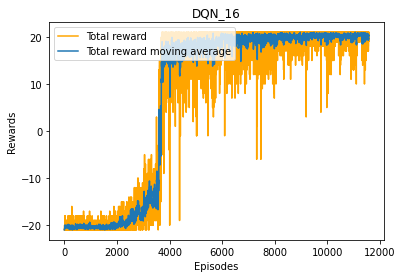

In [11]:
plot_training_rewards(rewards, 10)

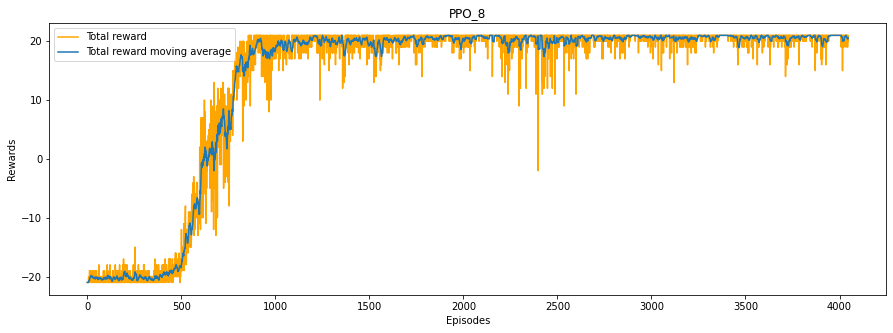

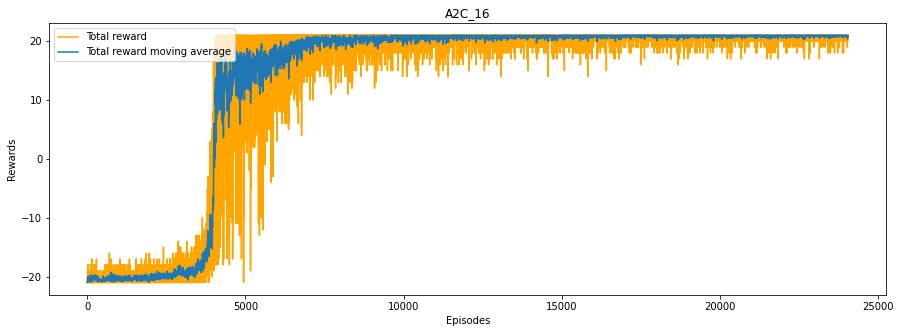

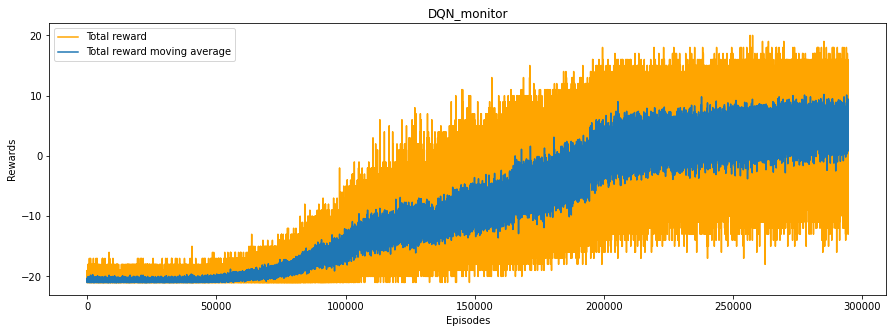

In [ ]:
plot_training_rewards(rewards, 10)

In questo ultimo grafico è rappresentato un confronto fra i tre algortimi studiati. SI può notare come PPO sia il migliore sia in termini di tempo, sia di precisione dei risultati; PPO è subito seguito da A2C anche esso con risultati soddisfacenti. Questi due algoritmi si distaccano notevolmente nel momento di un confronto con DQN: infatti, come si può vedere dal grafico, DQN ha performato molto peggio rispetto ai primi due. In 300 000 episodi è riuscito a raggiungere solo alla metà dei risultati che PPO ha compiuto in circa 500 episodi. Quindi possiamo dedurre che DQN non sia molto adatto a risolvere questo tipo di problemi legati all'apprendimento di un gioco semplice come Atari, mentre potrebbe essere impiegato per risolvere altri tipi di problemi più complessi, come ad esempio in ambito matematico. PPO rappresenta lo stato dell'arte ed è dimostrato dai risultati di questo grafico. Esso è perfetto per risolvere problemi appartenenti a questo dominio di ambiti.

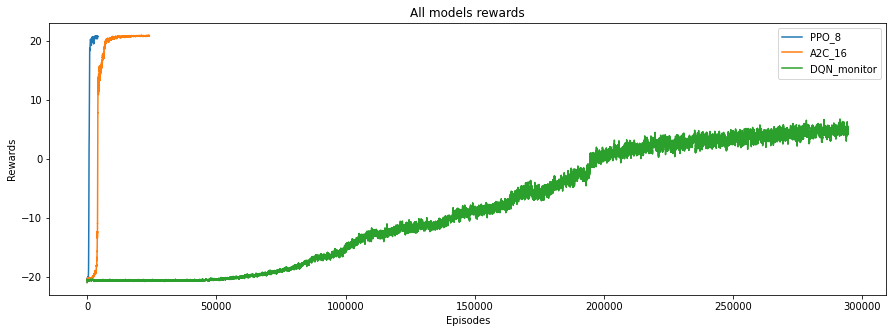

In [ ]:
plot_models_rewards(rewards, moving_avg_window_size)

Di seguito una GIF che mostra a video una partita giocata dalla macchina addestrata attraverso l'algortimo PPO

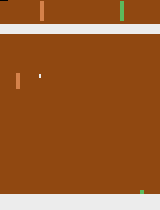